In [17]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [18]:
# Load and Normalize the data
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])   # means and std for each channel

train_data = datasets.CIFAR10(root='CIFAR10_Dataset', train=True, download = True, transform=t)
test_data = datasets.CIFAR10(root='CIFAR10_Dataset', train=False, download = False, transform=t)

Files already downloaded and verified


In [19]:
train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=100, shuffle=True)

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

truck


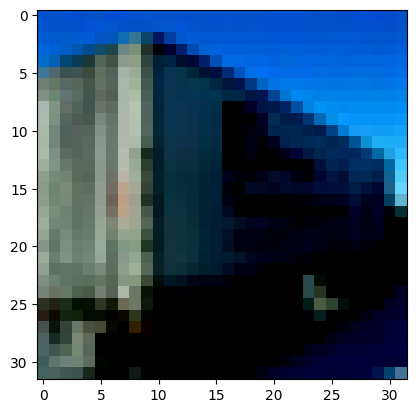

In [21]:
# Visualizing the normalized data
img, label = train_data[15]
plt.imshow(img.permute(1, 2, 0))
print(classes[label])

In [22]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [23]:
# Regular Neural Network
class ImageClassifier(nn.Module):

    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 10)
        self.dropout1 = nn.Dropout(0.4)     # Drop out 40% of the neurons
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
        self.batch_norm1 = nn.BatchNorm1d(512)      # Normalize the output from layer 1
        self.batch_norm2 = nn.BatchNorm1d(256)      # Normalize the output from layer 2

    def forward(self, img_batch):
        activation1 = F.relu(self.batch_norm1(self.layer1(self.dropout1(img_batch))))
        activation2 = F.relu(self.batch_norm2(self.layer2(self.dropout2(activation1))))
        output = self.layer3(self.dropout3(activation2))
        return output

# Convolutional Neural Network
class ImageClassifier2(nn.Module):

    def __init__(self):
        super(ImageClassifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # 32 + 2(1) - 3 + 1 = 32  (see formula in pytorch documentation)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32 / 2 = 16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 16 + 2(1) - 3 + 1 = 16
        # pooling layer: 16 / 2 = 8
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 8 + 2(1) - 3 + 1 = 8
        # pooling layer: 8 / 2 = 4
        # final shape = (100, 64, 4, 4)
        self.linear1 = nn.Linear(4*4*64, 500)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(500, 10)

    def forward(self, img_batch):
        a = F.relu(self.conv1(img_batch))
        a = self.pool(a)
        a = F.relu(self.conv2(a))
        a = self.pool(a)
        a = F.relu(self.conv3(a))
        a = self.pool(a)
        a = F.relu(self.linear1(a.flatten(1)))           # flatten the last three dimensions of the tensor
        output = self.linear2(self.dropout(a))
        return output

In [24]:
b = torch.ones(100, 2, 5, 5)
b = b.flatten(1)
b.shape

torch.Size([100, 50])

In [25]:
def train(dataset, loader, model, crit, optimizer, epochs):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # pick the GPU if it is available
    print("Device:", device)
    model = model.to(device)          # passes the model to the selected device
    model.train()                     # sets the model into training mode

    for epoch in range(epochs):
        full_loss = 0.0
        n_correct = 0

        for img_batch, labels in tqdm(loader):      # tqdm displays a progress bar as we iterate through the loop
            img_batch = img_batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model.forward(img_batch)
            predicted = outputs.argmax(dim=1)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()

            # we want the loss for every single training example so that we can calculate the average loss over the entire dataset
            full_loss += loss.item() * len(labels)
            n_correct += (predicted == labels.data).sum()     # keep track of the number of correct predictions to calculate accuracy

        average_loss = full_loss / len(dataset)
        accuracy = n_correct / len(dataset) * 100

        print(f"Epoch {epoch+1} training average loss: {average_loss:.3f}",
              f"with {accuracy:.2f}% accuracy")


def test(dataset, loader, model):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # pick the GPU if it is available
    print("Device:", device)
    model = model.to(device)
    model.eval()        # set the model to testing mode

    n_correct = 0
    with torch.no_grad():                       #torch.no_grad() disables computing gradients
        for img_batch, labels in tqdm(loader):
            img_batch = img_batch.to(device)
            labels = labels.to(device)
            outputs = model(img_batch)
            predicted = outputs.argmax(dim=1)
            n_correct += (predicted == labels.data).sum()

    accuracy = n_correct / len(dataset) * 100
    print(f"Test accuracy: {accuracy:.2f}%")

In [26]:
model = ImageClassifier2()
crit = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [27]:
for _ in range(5):
    train(train_data, train_loader, model, crit, optimizer, 3)
    test(test_data, test_loader, model)

Device: cuda:0


100%|██████████| 500/500 [00:15<00:00, 33.17it/s]


Epoch 1 training average loss: 1.936 with 28.42% accuracy


100%|██████████| 500/500 [00:14<00:00, 33.40it/s]


Epoch 2 training average loss: 1.396 with 49.47% accuracy


100%|██████████| 500/500 [00:14<00:00, 33.67it/s]


Epoch 3 training average loss: 1.159 with 58.68% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:02<00:00, 40.79it/s]


Test accuracy: 61.47%
Device: cuda:0


100%|██████████| 500/500 [00:16<00:00, 29.56it/s]


Epoch 1 training average loss: 0.996 with 64.80% accuracy


100%|██████████| 500/500 [00:14<00:00, 33.74it/s]


Epoch 2 training average loss: 0.879 with 69.09% accuracy


100%|██████████| 500/500 [00:15<00:00, 33.31it/s]


Epoch 3 training average loss: 0.775 with 72.67% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:02<00:00, 41.66it/s]


Test accuracy: 69.85%
Device: cuda:0


100%|██████████| 500/500 [00:14<00:00, 33.64it/s]


Epoch 1 training average loss: 0.698 with 75.56% accuracy


100%|██████████| 500/500 [00:14<00:00, 33.56it/s]


Epoch 2 training average loss: 0.630 with 77.88% accuracy


100%|██████████| 500/500 [00:15<00:00, 33.21it/s]


Epoch 3 training average loss: 0.560 with 80.36% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:03<00:00, 31.36it/s]


Test accuracy: 74.43%
Device: cuda:0


100%|██████████| 500/500 [00:15<00:00, 33.07it/s]


Epoch 1 training average loss: 0.495 with 82.58% accuracy


100%|██████████| 500/500 [00:15<00:00, 31.69it/s]


Epoch 2 training average loss: 0.433 with 84.69% accuracy


100%|██████████| 500/500 [00:15<00:00, 32.85it/s]


Epoch 3 training average loss: 0.379 with 86.53% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:02<00:00, 38.90it/s]


Test accuracy: 74.34%
Device: cuda:0


100%|██████████| 500/500 [00:15<00:00, 31.76it/s]


Epoch 1 training average loss: 0.329 with 88.38% accuracy


100%|██████████| 500/500 [00:15<00:00, 32.08it/s]


Epoch 2 training average loss: 0.287 with 89.78% accuracy


100%|██████████| 500/500 [00:15<00:00, 33.18it/s]


Epoch 3 training average loss: 0.248 with 91.22% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:02<00:00, 40.36it/s]

Test accuracy: 75.07%


In [ ]:
# Saving the trained model
PATH = "CIFAR10_Dataset/trained_model.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
# Saved Parameters
for par in model.state_dict():
    print(par)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
linear1.weight
linear1.bias
linear2.weight
linear2.bias


In [ ]:
# Loading the saved model
model = ImageClassifier2()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
test(test_data, test_loader, model)

Device: cuda:0


100%|██████████| 100/100 [00:03<00:00, 27.27it/s]

Test accuracy: 73.87%


In [ ]:
import random
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.cuda(), labels.cuda()

In [ ]:
outputs = model(images)
predicted = outputs.argmax(dim=1)

Actual: dog
Predicted: dog


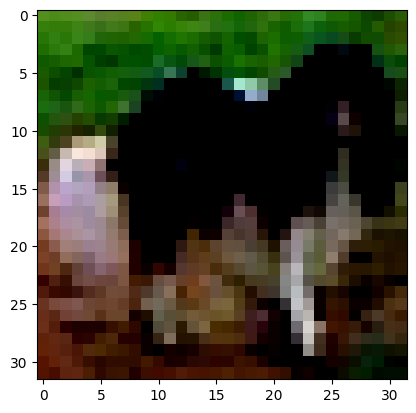

In [ ]:
i = random.randint(0, len(labels) - 1)
img, label = images[i].cpu(), labels[i].cpu()
plt.imshow(img.permute(1, 2, 0))
print(f"Actual: {classes[label]}")
print(f"Predicted: {classes[predicted[i]]}")